In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct
from scipy.stats import binom, poisson, norm


mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = True
pathFigures = '/home/thea/MesterTesen/WrittenWork/Figures/'


import sys

sys.path.append('../../')
sys.path.append('../')

from GetCoreData_fct import GetCoreData
from BackDiffuse_LT import BackDiffuse
from Interpolation_Class import Interpolation
from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength
from transforms import transforms
from Decon import SpectralDecon
from sigmaSolver import sigma_Solver
from SignalAttenuation import Attenuation, AnnualLayerThick


def func_gaussian(x, N, mu, sigma, a):
    
    return N * norm.pdf(x, mu, sigma) + a

In [2]:
from GetCoreData_fct import GetDensProfile
print('Creating density profile')
core = 'Dye3'

pathDens = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/' + core + '_DepthDens.txt'
pathOut = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/' + core + 'DepthDens_w_Models.txt'
pathIso = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+core+'_det.txt'

delimIso = ','
delimOut = '\t'
delimDens = '\t'

GetDensProfile(site_in = core, path_densMeas=pathDens,delim_densMeas=delimDens, path_isoMeas=pathIso, delim_isoMeas=delimIso, path_outFile=pathOut, delim_outFile=delimOut, area_in='Alphabet', zMeas_str = 'depth', densMeas_str = 'density')


Creating density profile
No density measurements. Creating purely analytical profile.


<ipython-input-2-5a468777778e>:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  GetDensProfile(site_in = core, path_densMeas=pathDens,delim_densMeas=delimDens, path_isoMeas=pathIso, delim_isoMeas=delimIso, path_outFile=pathOut, delim_outFile=delimOut, area_in='Alphabet', zMeas_str = 'depth', densMeas_str = 'density')


In [3]:
from GetCoreData_fct import GetDiffProfile

print('Creating diffusion length profile')
PathDens = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/' + core + '_DepthDens.txt'
PathOut = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/' + core + '_DepthDiff.txt'
PathIso = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+core+'_det.txt'
DelimIso = ','
DelimOut = '\t'
DelimDens = '\t'
GetDiffProfile(site_in=core, path_outFile=PathOut, delim_outFile=DelimOut, path_densMeas=PathDens, delim_densMeas=DelimDens, path_isoMeas=PathIso, delim_isoMeas=DelimIso)


Creating diffusion length profile
No density measurements. Creating purely analytical profile.


<ipython-input-3-ec5103a54a73>:10: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  GetDiffProfile(site_in=core, path_outFile=PathOut, delim_outFile=DelimOut, path_densMeas=PathDens, delim_densMeas=DelimDens, path_isoMeas=PathIso, delim_isoMeas=DelimIso)


In [82]:
site = 'Crete'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


No ECM file found, setting empty df instead


<ipython-input-82-d94deb82c1b0>:17: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


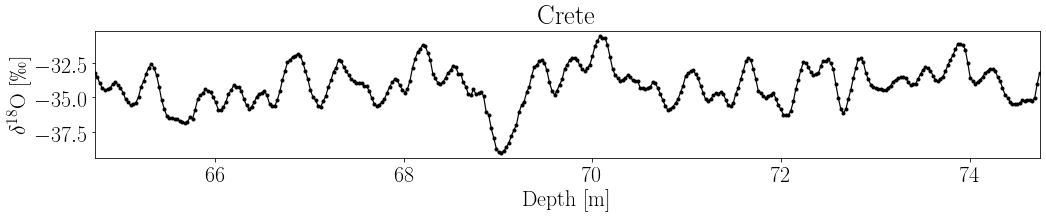

In [94]:
fig, ax = plt.subplots(figsize=(15,3.5))
ax.plot(depth_LT,d18O_LT, c='k', lw=1.2, marker='.')
ax.set(xlim=(min(depth_LT), max(depth_LT)), title=site, xlabel='Depth [m]', ylabel='$\delta^{18}$O [$\permil$]')

fig.tight_layout()

if saveFigs:
    fig.savefig(pathFigures + site + '_dO18Profile_raw.pdf', bbox_inches='tight')

In [6]:
dataAll = pd.DataFrame({'depth':depth,'d18O':d18O}, index=None)

inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30, transType = 'NDCT')
dep, dat, diff, Ps, Ts, pats = inst.BackDiffused_constraints()

ALT file exists. Loading ALT data.
Sigma fit: 7.20
Min sigma analyt: 7.28
Starting sigma: 5.20 [cm]
6.0
Final sigma: 7.22 [cm]
Final # of peaks: 33
Delta: 0.026
Delta new: 0.013


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


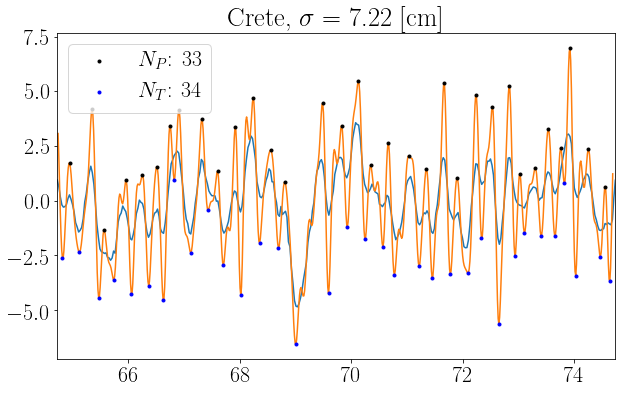

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(depth_LT,d18O_LT-np.mean(d18O_LT))
ax.plot(dep,dat)
ax.plot(dep[Ps],dat[Ps],'.', color='k', label='$N_P$: '+f'{len(Ps)}')
ax.plot(dep[Ts],dat[Ts],'.', color='b', label='$N_T$: '+f'{len(Ts)}')
ax.set(xlim=(min(depth_LT), max(depth_LT)), title=site+f', $\sigma=$ {diff*100:.2f} [cm]')
ax.legend()

# Density profiles

In [8]:
coreNames = CoresSpecs['CoreName']

site = 'Crete'
core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = np.float64(CoreSpecs['dTamb'])
dLaki = np.float64(CoreSpecs['dLaki'])
Accum0 = np.float64(CoreSpecs['Accum0'])
T0 = np.float64(CoreSpecs['T0'])
dens0 = np.float64(CoreSpecs['dens0'])
z0 = np.float64(CoreSpecs['z0'])



In [9]:
site_Dens = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/'+ site + 'DepthDens_w_Models.txt', '\t')
site_Diff = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/'+ site + '_DepthDiff.txt', '\t')
#site_ECM = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetECM/'+ site + '_ECM.txt', ',') 
site_d18O =  pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+ site + '_det.txt', ',')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:

    # Define diffusion length measurements: o18, o17 and D. Define btw. Laki and Tamb.
depthDiff = site_Diff['Depth']
sigma_D = site_Diff['sigma_D']
sigma_o18 = site_Diff['sigma_o18']
sigma_o17 = site_Diff['sigma_o17']
depthDiff_LT = depthDiff[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_o18_LT = sigma_o18[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_o17_LT = sigma_o17[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_D_LT = sigma_D[(depthDiff >= dTamb) & (depthDiff <= dLaki)]

    # Define ECM data. Define btw. Laki and Tamb.
#depthECM = site_ECM['depth']
#ECM = site_ECM['ECM']
#depthECM_LT = depthECM[(depthECM >= dTamb) & (depthECM <= dLaki)]
#ECM_LT = ECM[(depthECM >= dTamb) & (depthECM <= dLaki)]

    # Define d18O details data. Define btw. Laki and Tamb.
depth = site_d18O['depth'][1:]
d18O = site_d18O['d18O'][1:]
depth_LT = site_d18O['depth'][(site_d18O['depth'] >= dTamb) & (site_d18O['depth'] <= dLaki)]
d18O_LT = site_d18O['d18O'][(site_d18O['depth'] >= dTamb) & (site_d18O['depth'] <= dLaki)]

    # Define density measurements: raw, model and fudged model. Define btw. Laki and Tamb.
depthRho = site_Dens['depth']
depthRho_LT = depthRho[(depthRho >= dTamb) & (depthRho <= dLaki)]

HLmodel = site_Dens['HLmodel']
HLmodel_LT = HLmodel[(depthRho >= dTamb) & (depthRho <= dLaki)]

#HLmodelOpti = site_Dens['HLmodelOpti']
#HLmodelOpti_LT =HLmodelOpti[(depthRho >= dTamb) & (depthRho <= dLaki)]
#rhoMeas = site_Dens['rhoMeas']
#rhoMeas_LT = rhoMeas[(depthRho >= dTamb) & (depthRho <= dLaki)]


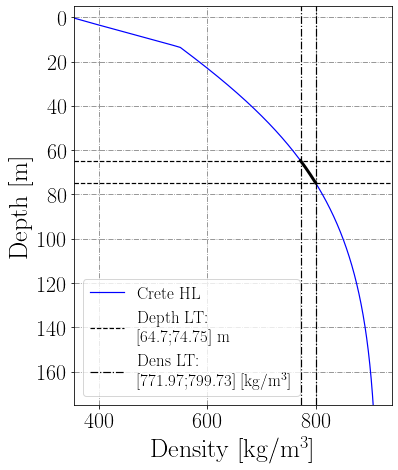

In [51]:
fig1, ax1 = plt.subplots(figsize=(6,7))

ax1.set_xlabel('Density [kg/m$^3$]',fontsize=26) 
ax1.set_ylabel('Depth [m] ', fontsize=26)
ax1.invert_yaxis()
ax1.plot(HLmodel*1000, depthRho, c='b', label=site+' HL', lw=1.2)
ax1.plot(HLmodel_LT*1000,depth_LT, 'k', lw=3)
ax1.grid(True, color='grey',ls='-.')
#ax1.plot(HLmodelOpti*1000, depthRho, label=f'Crete HL w. fudge')#\nf0 = {f0:.2f} f1 = {f1:.2f}')
ax1.axhline(y=dTamb, ls='--', c='k', lw=1.2, label=f'Depth LT: \n[{dTamb};{dLaki}] m')
ax1.axhline(y=dLaki, ls='--', c='k', lw=1.2)
ax1.axvline(x=min(HLmodel_LT)*1000, ls='-.', c='k', lw=1.2, label='Dens LT: \n'+f'[{min(HLmodel_LT)*1000:.2f};{max(HLmodel_LT)*1000:.2f}] [kg/m$^3$]')
ax1.axvline(x=max(HLmodel_LT)*1000, ls='-.', c='k', lw=1.2)
#ax1.step(rhoMeas, depthRho,'k',lw=1,label='Site A measured')
#ax1.grid(True, color='grey',ls='-.')
ax1.legend(fontsize=17)
fig1.tight_layout()
ax1.set_ylim((175,-5))
ax1.set_xlim((min(HLmodel)*1000,940))
saveFigs=True
if saveFigs:
    fig1.savefig(pathFigures + site + '_DensProfile_wHL.pdf', bbox_inches='tight')

# Diffusion Profile

Max sigma, theoretically: 0.075
Min sigma, theoretically: 0.073


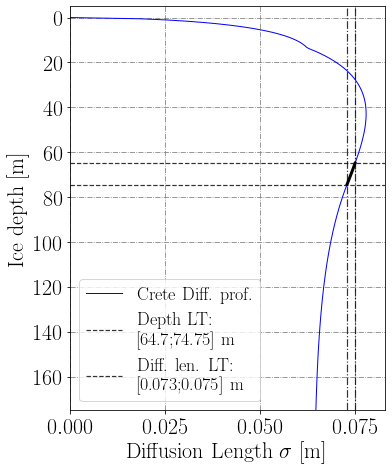

In [52]:
figDiff, axDiff = plt.subplots(figsize=(6,7))

axDiff.set(xlabel='Diffusion Length $\sigma$ [m]', ylabel='Ice depth [m]')
axDiff.invert_yaxis()
axDiff.plot(sigma_o18,depthDiff, 'b', lw=1, label = site + ' Diff. prof.')
axDiff.plot(sigma_o18_LT,depthDiff_LT, 'k', lw=3)
axDiff.axhline(y = dTamb, alpha=0.8, color='k', ls='--', lw=1.2, label=f'Depth LT: \n[{dTamb};{dLaki}] m')
axDiff.axhline(y = dLaki, alpha=0.8, color='k', ls='--', lw=1.2, label='Diff. len. LT: \n'+f'[{min(sigma_o18_LT):.3f};{max(sigma_o18_LT):.3f}] m')
axDiff.axvline(x = sigma_o18_LT.values[0], alpha=0.8, color='k', ls='-.', lw=1.2)
axDiff.axvline(x = sigma_o18_LT.values[-1], alpha=0.8, color='k', ls='-.', lw=1.2)
axDiff.set(xlim=(0, max(sigma_o18)+0.005), ylim=(175,-5))
axDiff.grid(True, color='grey',ls='-.')
axDiff.legend(fontsize=18)
figDiff.tight_layout()
#if saveFigs:
#    figDiff.savefig('../../WrittenWork/NovemberPresentation/SiteA_DiffLen.jpg')
sigmaMax_theo = sigma_o18_LT.max()
sigmaMin_theo = sigma_o18_LT.min()
print(f'Max sigma, theoretically: {sigma_o18_LT.max():.3f}')
print(f'Min sigma, theoretically: {sigma_o18_LT.min():.3f}')

if saveFigs:
    figDiff.savefig(pathFigures + site + '_DiffProfile.pdf', bbox_inches='tight')

# Site A ECM

In [2]:

site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-2-b2f2dce78825>:17: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


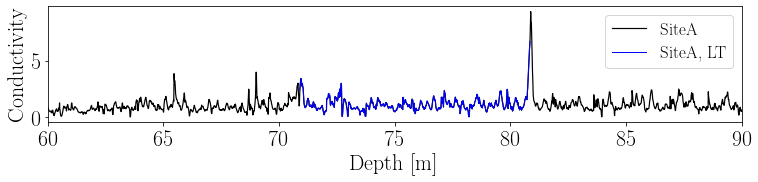

In [8]:
fig, ax = plt.subplots(figsize=(11,3))
ax.plot(data_ECM['depth'], data_ECM['ECM'], lw=1.2, c='k', label=site)
ax.plot(data_ECM_LT['depth'], data_ECM_LT['ECM'], lw=1, c='b', label=site+', LT')
ax.set(xlim=(60,90), xlabel='Depth [m]', ylabel='Conductivity')
ax.legend(fontsize=17)
fig.tight_layout()
if saveFigs:
    fig.savefig(pathFigures + site + '_ECM_only.pdf', bbox_inches='tight')

In [55]:

data_ECM

,depth,ECM
0,1.11,0.99
1,1.12,1.13
2,1.13,1.16
3,1.14,1.18
4,1.15,1.06
...,...,...
12747,128.58,1.78
12748,128.59,2.19
12749,128.60,2.24
12750,128.61,2.32


# 33 yrs cycle

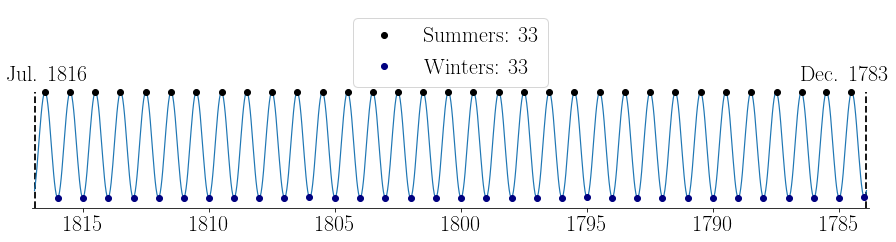

In [74]:
x = 1784 - 1/12 + np.linspace(0,33,1000)

l = 1
m = 6
p = (2*np.pi*m/12)
y = np.cos((2*np.pi*x - p)/l)


fig, ax = plt.subplots(figsize=(15,3.7), frameon=False)

ax.plot(x,y,lw=1.2)
ax.set(xlim=(min(x)-0.1,max(x)+0.1), ylim=(-1.2,2.6))

from scipy import signal

ps = signal.find_peaks(y)[0]
ts = signal.find_peaks(-y)[0]

ax.plot(x[ps], y[ps],'o', c='k', label=f'Summers: {len(ps)}')
ax.plot(x[ts], y[ts],'o',c='navy', label=f'Winters: {len(ts)}')
ax.invert_xaxis()
ax.axes.yaxis.set_visible(False)
ax.text(1818,1.2,'Jul. 1816', fontsize=22)
ax.text(1786.5,1.2,'Dec. 1783', fontsize=22)
#ax.axes.xaxis.set_ticklabels([])
ax.vlines(min(x),-1.2,1, lw=1.8, ls='--', color='k')
ax.vlines(max(x),-1.2,1, lw=1.8, ls='--', color='k')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(fontsize=22, loc='upper center')

fig.savefig('../WrittenWork/Figures/summersWinters_LT.pdf', bbox_inches='tight')

# 2 mnth variation

In [75]:
site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb_in = CoreSpecs['dTambCor']
dLaki_in = CoreSpecs['dLakiCor']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-75-b90b309d1d48>:14: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


In [76]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

data = pd.read_csv(pathResults + site + '_ALT_FullCore_Pshift_'+str(int(1.5))+'_lSecs_'+str(7)+'.csv')

lDCT = np.asarray(data['lDCT']);lNDCT = np.asarray(data['lNDCT']);lFFT = np.asarray(data['lFFT']);
vals_use = data['depth']

lks = np.c_[lDCT,lNDCT,lFFT]
lks_LT = lks[(vals_use>=dTamb_in)&(vals_use<=dLaki_in)]


def avg(a):
    return a[a > 0].mean()
def std(a):
    return a[a>0].std()

l_LT = avg(lks_LT)
lStd_LT = std(lks_LT)

In [77]:
MLT = l_LT/6

mu = dTamb_in
mu2 = dLaki_in
sig = MLT

ds = np.linspace(dTamb_in-2,dLaki_in+2, 1000)
fs = func_gaussian(ds, 1, mu, sig, 0)
fs2 = func_gaussian(ds, 1, mu2, sig, 0)


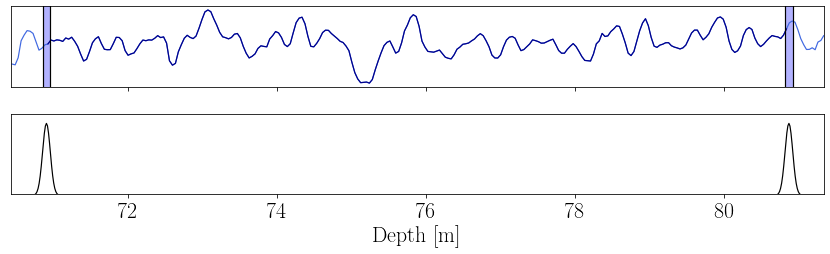

In [81]:
fig, ax = plt.subplots(2,1,figsize=(12,4), sharex=True)
delt = .5
ax[0].plot(depth[(depth > dTamb_in - delt) & (depth < dLaki_in + delt)],d18O[(depth > dTamb_in - delt) & (depth < dLaki_in + delt)], c='royalblue', lw=1.2)
ax[0].plot(depth_LT, d18O_LT, c='darkblue', lw=1.2)
ax[0].set(xlim=(min(depth_LT)-delt,max(depth_LT)+delt))
ax[0].axvline(mu-sig, lw=1.2, c='k')
ax[0].axvline(mu+sig,lw=1.2, c='k')

ax[0].axvline(dLaki_in-sig, lw=1.2, c='k')
ax[0].axvline(dLaki_in+sig,lw=1.2, c='k')
ax[0].axvspan(dLaki_in-sig, dLaki_in+sig, alpha=0.3, color='b')
ax[0].axvspan(dTamb_in-sig, dTamb_in+sig, alpha=0.3, color='b')

ax[1].plot(ds,fs, c='k', lw=1.2)
ax[1].plot(ds,fs2, c='k', lw=1.2)
ax[1].set(ylim=(0.1,max(fs)+1), xlabel='Depth [m]')
ax[1].axes.yaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
fig.tight_layout()

if saveFigs:
    fig.savefig(pathFigures + site + '_LandT_Gauss_2Mnth2.pdf', bbox_inches='tight')

# Spectral analysis of Crete

In [95]:
sites = ['B19','B22','B23','SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG', 'Crete']
N_InInts = [33, 33, 33, 33, 33, 33]
Nt_InInts = [33, 33, 33, 33, 33, 33]

j = -1

site = sites[j]
N_InInt = N_InInts[j]

N_InInt_test = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet') #'AWI_Bcores'

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth'][1:]
d18O = data_d18O['d18O'][1:]
depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

depthECM = data_ECM['depth']
ECM = data_ECM['ECM']
depthECM_LT = data_ECM_LT['depth']
ECM_LT = data_ECM_LT['ECM']


No ECM file found, setting empty df instead


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-95-db69290d4ef2>:25: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet') #'AWI_Bcores'


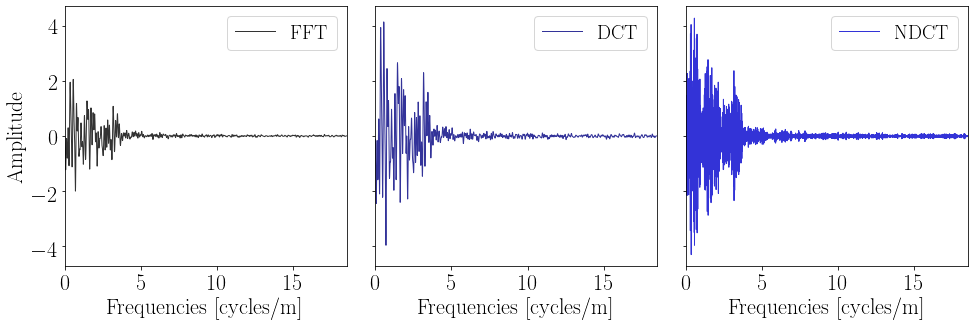

In [120]:
from Decon import SpectralDecon
depth = np.asarray(depth_LT)
d18O = np.asarray(d18O_LT)

instFFT = SpectralDecon(depth, d18O, 2000, 'FFT')
instDCT = SpectralDecon(depth, d18O, 2000, 'DCT')
instNDCT = SpectralDecon(depth, d18O, 2000, 'NDCT')

fS_fft, S_fft, _ = instFFT.fft()
S_fft = np.real(S_fft[np.where(fS_fft >= 0)])
fS_dct, S_dct = instDCT.dct()
fS_ndct, S_ndct = instNDCT.Ndct()



f_fft, PSD_fft = instFFT.dct_psd()
f_dct, PSD_dct = instDCT.dct_psd()
f_ndct, PSD_ndct = instNDCT.dct_psd()

fig, ax = plt.subplots(1,3,figsize=(14,5), sharey=True)


ax[0].plot(fS_fft[1:], S_fft[1:], 'k', lw=1, alpha=0.8, label = 'FFT')
ax[1].plot(fS_dct[1:], S_dct[1:], 'navy', alpha = 0.8, lw=1, label = 'DCT')
ax[2].plot(fS_ndct[1:], S_ndct[1:], 'mediumblue', alpha=0.8, lw=1, label = 'NDCT')

ax[0].set(xlim=(min(f_fft), max(f_fft))); ax[0].set_xlabel('Frequencies [cycles/m]', fontsize=22); ax[0].set_ylabel('Amplitude', fontsize=22); ax[0].legend(fontsize=20)
ax[1].set(xlim=(min(f_fft), max(f_fft))); ax[1].set_xlabel('Frequencies [cycles/m]', fontsize=22); ax[1].legend(fontsize=20)
ax[2].set(xlim=(min(f_fft), max(f_fft))); ax[2].set_xlabel('Frequencies [cycles/m]', fontsize=22); ax[2].legend(fontsize=20)
fig.tight_layout()

if saveFigs:
    fig.savefig(pathFigures+site+'_SpectralTransforms_3.pdf', box_inches='tight')

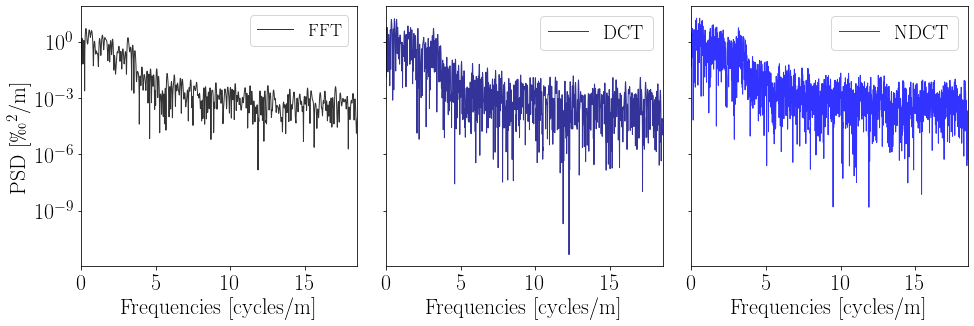

In [121]:
fig, ax = plt.subplots(1,3,figsize=(14,5), sharey=True)

ax[0].semilogy(f_fft[1:], PSD_fft[1:], 'k', lw=1, alpha=0.8, label = 'FFT')
ax[1].semilogy(f_dct[1:], PSD_dct[1:], 'navy', alpha = 0.8, lw=1, label = 'DCT')
ax[2].semilogy(f_ndct[1:], PSD_ndct[1:], 'b', alpha=0.8, lw=1, label = 'NDCT')

ax[0].set(xlim=(min(f_fft), max(f_fft)), xlabel = 'Frequencies [cycles/m]', ylabel = 'PSD [$\permil$$^2$/m]'); ax[0].legend(fontsize=18)
ax[1].set(xlim=(min(f_fft), max(f_fft)), xlabel = 'Frequencies [cycles/m]'); ax[1].legend(fontsize=20)
ax[2].set(xlim=(min(f_fft), max(f_fft)), xlabel = 'Frequencies [cycles/m]'); ax[2].legend(fontsize=20)
fig.tight_layout()
if saveFigs:
    fig.savefig(pathFigures+site+'_SpectralTransforms_PSD.pdf', box_inches='tight')

In [122]:
fit_fft = instFFT.SpectralFit()
fit_dct = instDCT.SpectralFit()
fit_ndct = instNDCT.SpectralFit()

Fit Parameters:

P0 = 0.8747093596398039
Var = 0.1900374936472657
s_eta2 = 0.1900374936472657 m
Diff len = 7.5860709370865145 cm
a1 = 0.4
Diff. len., fit [cm]: 7.586
Fit Parameters:

P0 = 0.9708024384047891
Var = 0.17838051174275285
s_eta2 = 0.17838051174275285 m
Diff len = 7.685445374498865 cm
a1 = 0.4
Diff. len., fit [cm]: 7.685
Fit Parameters:

P0 = 0.8080515868740268
Var = 0.21036203598099415
s_eta2 = 0.21036203598099415 m
Diff len = 7.258841509489322 cm
a1 = 0.4
Diff. len., fit [cm]: 7.259


In [123]:

w_fft, P_fft, Pnoise_fft, Psignal_fft, P_fit_fft, opt_fit_dict_fft, _, _, _ = fit_fft
w_dct, P_dct, Pnoise_dct, Psignal_dct, P_fit_dct, opt_fit_dict_dct, _, _, _ = fit_dct
w_ndct, P_ndct, Pnoise_ndct, Psignal_ndct, P_fit_ndct, opt_fit_dict_ndct, _, _, _ = fit_ndct

In [124]:
sigma_fft = opt_fit_dict_fft['s_tot2_fit']
sigma_dct = opt_fit_dict_dct['s_tot2_fit']
sigma_ndct = opt_fit_dict_ndct['s_tot2_fit']

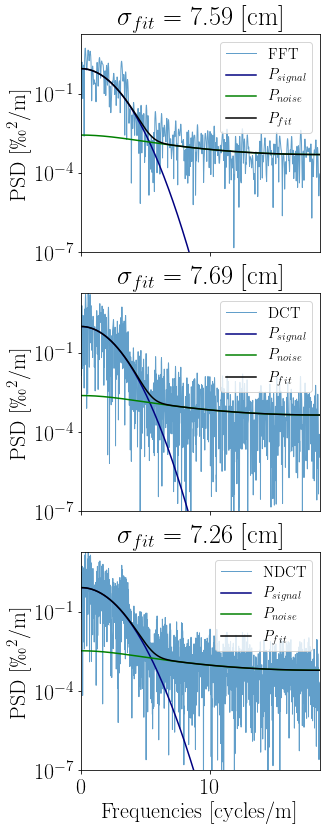

In [142]:
fig, ax = plt.subplots(3,1,figsize=(5,10), sharex=True)

ax[0].semilogy(f_fft[1:], PSD_fft[1:], 'C0', lw=1, alpha=0.7, label = 'FFT')
ax[0].semilogy(w_fft, Psignal_fft, lw=1.5, c='navy', label = '$P_{signal}$')
ax[0].semilogy(w_fft, Pnoise_fft, lw=1.5, c='green', label = '$P_{noise}$')
ax[0].semilogy(w_fft, P_fit_fft, lw=1.5, c='k', label = '$P_{fit}$')
ax[0].set(xlim=(min(f_fft), max(f_fft)), ylim=(1e-7, max(PSD_dct)), ylabel = 'PSD [$\permil$$^2$/m]', title = '$\sigma_{fit} = $'+f' {sigma_fft*100:.2f} [cm]')
ax[0].legend(fontsize=15, loc = 'upper right')


ax[1].semilogy(f_dct[1:], PSD_dct[1:], 'C0', alpha = 0.7, lw=1, label = 'DCT')
ax[1].semilogy(w_dct, Psignal_dct, lw=1.5, c='navy', label = '$P_{signal}$')
ax[1].semilogy(w_dct, Pnoise_dct, lw=1.5, c='green', label = '$P_{noise}$')
ax[1].semilogy(w_dct, P_fit_dct, lw=1.5, c='k', label = '$P_{fit}$')
ax[1].set(ylim=(1e-7, max(PSD_dct)),title = '$\sigma_{fit} = $'+f' {sigma_dct*100:.2f} [cm]', ylabel = 'PSD [$\permil$$^2$/m]')
ax[1].legend(fontsize=15, loc = 'upper right')


ax[2].semilogy(f_ndct[1:], PSD_ndct[1:], 'C0', alpha=0.7, lw=1, label = 'NDCT')
ax[2].semilogy(w_ndct, Psignal_ndct, lw=1.5, c='navy', label = '$P_{signal}$')
ax[2].semilogy(w_ndct, Pnoise_ndct, lw=1.5, c='green', label = '$P_{noise}$')
ax[2].semilogy(w_ndct, P_fit_ndct, lw=1.5, c='k', label = '$P_{fit}$')
ax[2].set(ylim=(1e-7, max(PSD_dct)), xlabel = 'Frequencies [cycles/m]', title = '$\sigma_{fit} = $'+f' {sigma_ndct*100:.2f} [cm]', ylabel = 'PSD [$\permil$$^2$/m]')
ax[2].legend(fontsize=15, loc = 'upper right')



fig.tight_layout(w_pad=0.05, h_pad=0.05)

if saveFigs:
    fig.savefig(pathFigures+site+'SpectralTransforms_PSDwFitsVert.pdf', box_inches='tight')

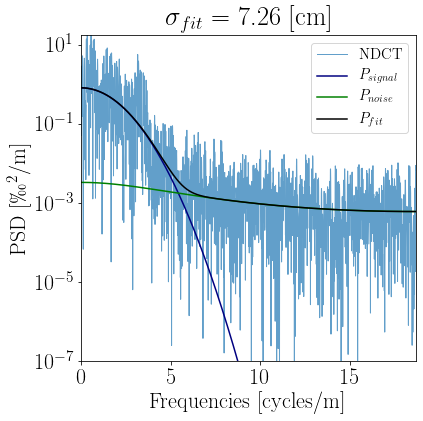

In [149]:
fig, ax = plt.subplots(figsize=(6,6))

ax.semilogy(f_ndct[1:], PSD_ndct[1:], 'C0', alpha=0.7, lw=1, label = 'NDCT')
ax.semilogy(w_ndct, Psignal_ndct, lw=1.5, c='navy', label = '$P_{signal}$')
ax.semilogy(w_ndct, Pnoise_ndct, lw=1.5, c='green', label = '$P_{noise}$')
ax.semilogy(w_ndct, P_fit_ndct, lw=1.5, c='k', label = '$P_{fit}$')
ax.set(xlim=(min(f_ndct), max(f_ndct)), ylim=(1e-7, max(PSD_dct)), xlabel = 'Frequencies [cycles/m]', title = '$\sigma_{fit} = $'+f' {sigma_ndct*100:.2f} [cm]', ylabel = 'PSD [$\permil$$^2$/m]')
ax.legend(fontsize=15, loc = 'upper right')

if saveFigs:
    fig.savefig(pathFigures+site+'NDCT_PSDwFits.pdf', box_inches='tight')

# Crete ALT profile

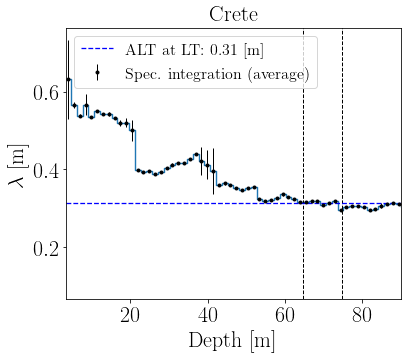

In [161]:
site = 'Crete'
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')


coreNames = CoresSpecs['CoreName']

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']

fig, ax = plt.subplots(figsize=(6,5))

data = pd.read_csv(pathResults + site + '_ALT_FullCore_Pshift_1_lSecs_7.csv')
lMean = data['lMean']
lStd = data['lStd']
secs = data['depth']

l_LT = np.mean(lMean[(secs >= dTamb) & (secs <= dLaki)])

ax.step(secs, lMean, where='mid', lw=1.4)
ax.errorbar(secs, lMean, lStd, c='k', fmt='.', lw=1, label='Spec. integration (average)')
ax.set_title(site, fontsize=22)
if max(secs) < 200:
    ax.set_xlim((min(secs)-0.5, max(secs)+1))
else:
    ax.set_xlim((min(secs)-0.5, 90))
ax.set_xlabel('Depth [m]')
ax.set_ylabel('$\lambda$ [m]')
ax.axvline(dLaki, lw=1, ls='--', c='k')
ax.axvline(dTamb, lw=1, ls='--', c='k')
ax.axhline(l_LT, lw=1.3, ls='--', c='b', label = f'ALT at LT: {l_LT:.2f} [m]')
ax.legend(fontsize=16)

if saveFigs:
    fig.savefig(pathFigures + site+'_ALT.pdf', bbox_inches='tight')

# Crete Constraints V No Constraints

# Crete top

In [9]:
sites = ['B19','B22','B23','SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG', 'Crete']
N_InInts = [33, 33, 33, 33, 33, 33]
Nt_InInts = [33, 33, 33, 33, 33, 33]

j = -1

site = sites[j]
N_InInt = N_InInts[j]

N_InInt_test = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet') #'AWI_Bcores'

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth'][1:]
d18O = data_d18O['d18O'][1:]
depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

depthECM = data_ECM['depth']
ECM = data_ECM['ECM']
depthECM_LT = data_ECM_LT['depth']
ECM_LT = data_ECM_LT['ECM']


No ECM file found, setting empty df instead


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-9-db69290d4ef2>:25: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet') #'AWI_Bcores'


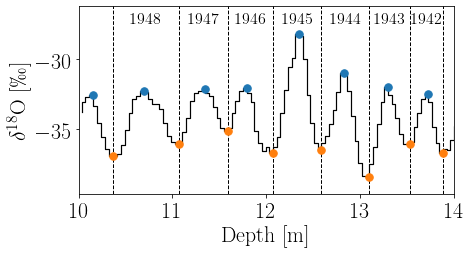

In [32]:
top_min = 10
top_max = 20
depth_top = np.asarray(depth[(depth > top_min) & (depth < top_max)])
d18O_top = np.asarray(d18O[(depth > top_min) & (depth < top_max)])
troughs = signal.find_peaks(-d18O_top, distance=7)[0]
peaks = signal.find_peaks(d18O_top, distance=7)[0]
#yrs = np.linspace(1956,1939,1956-1939+1, dtype=int)
yrs = np.linspace(1948,1942,1948-1942+1, dtype=int)
xs = depth_top[troughs][:-1] + np.diff(depth_top[troughs])/2

fig, ax = plt.subplots(figsize=(7,4))

ax.step(depth_top,d18O_top, lw=1.2, c='k')
ax.set(xlim=(top_min,14), ylabel='$\delta^{18}$O [$\permil$]', xlabel='Depth [m]', ylim=(min(d18O_top)-1, max(d18O_top)+2));

for i in range(len(troughs)):
    ax.axvline(depth_top[troughs[i]], c='k', ls='--', lw=1)
    if i < len(yrs):
        ax.text(xs[i],-27.5, yrs[i], fontsize=16, ha='center')
ax.plot(depth_top[peaks],d18O_top[peaks], '.', ms=15)
ax.plot(depth_top[troughs],d18O_top[troughs], '.', ms=15)

fig.tight_layout()

saveFigs = True
if saveFigs:
    fig.savefig(pathFigures+'Crete_5m_PeaksTroughs.pdf', bbox_inches='tight')

# Diffusion lengths, Optimal

In [ ]:
coreNames = CoresSpecs['CoreName']

site = 'Crete'
core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = np.float64(CoreSpecs['dTamb'])
dLaki = np.float64(CoreSpecs['dLaki'])
Accum0 = np.float64(CoreSpecs['Accum0'])
T0 = np.float64(CoreSpecs['T0'])
dens0 = np.float64(CoreSpecs['dens0'])
z0 = np.float64(CoreSpecs['z0'])

site_Diff = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/'+ site + '_DepthDiff.txt', '\t')



	##########SiteA##########
Average sampling size in interval: 3.92 +/- 0.06 [cm]

Opt. diff. len.: 7.37 +/- 0.54
Firn diff. len.: 7.27 +/- 0.55

	##########SiteB##########
Average sampling size in interval: 3.89 +/- 0.06 [cm]

Opt. diff. len.: 7.35 +/- 0.22
Firn diff. len.: 7.26 +/- 0.22

	##########SiteD##########
Average sampling size in interval: 3.77 +/- 0.06 [cm]

Opt. diff. len.: 7.21 +/- 0.28
Firn diff. len.: 7.12 +/- 0.28


<ipython-input-53-97dd87d81f3e>:21: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')



	##########SiteE##########
Average sampling size in interval: 4.25 +/- 0.07 [cm]

Opt. diff. len.: 8.22 +/- 0.15
Firn diff. len.: 8.12 +/- 0.15

	##########SiteG##########
Average sampling size in interval: 4.10 +/- 0.07 [cm]

Opt. diff. len.: 9.46 +/- 0.24
Firn diff. len.: 9.38 +/- 0.24

	##########Crete##########
No ECM file found, setting empty df instead
Average sampling size in interval: 2.68 +/- 0.05 [cm]

Opt. diff. len.: 7.08 +/- 0.19
Firn diff. len.: 7.03 +/- 0.19


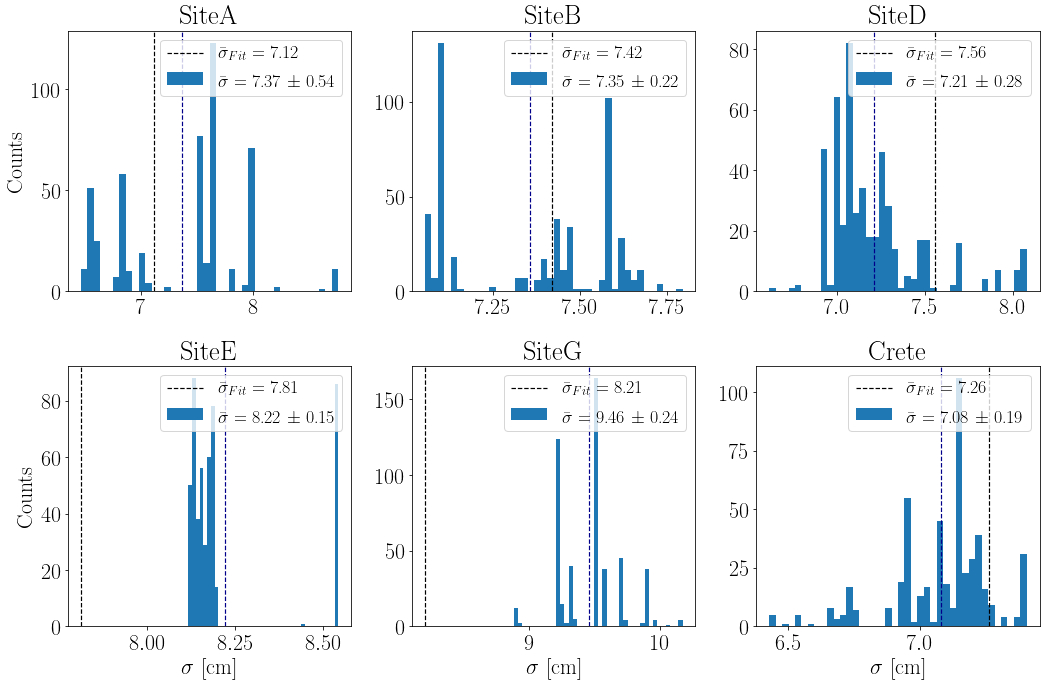

In [53]:
from DiffusionProfiles_calculations import sampling_sigma
sigmaFit = [7.12, 7.42, 7.56, 7.81, 8.21, 7.26]

sites = ['SiteA', 'SiteB','SiteD', 'SiteE', 'SiteG', 'Crete']

fig, axs = plt.subplots(2,3, figsize=(15,10))
i = 0
for site, ax in zip(sites, axs.flatten()):
    print('\n\t##########'+site+'##########')
    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
    coreNames = CoresSpecs['CoreName']


    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTamb = CoreSpecs['dTamb']
    dLaki = CoreSpecs['dLaki']
    accum0 = CoreSpecs['Accum0']
    accumIE = CoreSpecs['Accum1']
    Temp0 = CoreSpecs['T0']+273.15
    DataAll = GetCoreData(site, 'Alphabet')

    data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
    data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
    data_dens = DataAll[4]; data_dens_LT = DataAll[5]
    data_diff = DataAll[6]; data_diff_LT = DataAll[7]
    
    depth_diff = data_diff['Depth']
    sigma_o18 = data_diff['sigma_o18']
    sigma_o18_LT = sigma_o18[(depth_diff >= dTamb) & (depth_diff <= dLaki)]
    
    sigmaTheoMean = np.mean(sigma_o18_LT)
    
    depth = data_d18O['depth']
    d18O = data_d18O['d18O']

    depth_LT = data_d18O_LT['depth']
    d18O_LT = data_d18O_LT['d18O']
    
    if site == 'SiteG' or site == 'Crete':
        dens_LT = data_dens_LT['HLmodel']
    else:
        dens_LT = data_dens_LT['HLmodelOpti']

    pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

    diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'_diffLens_GaussDistwDepths_sigNmonths2_NDCT2.csv', ' ', header=None))
    sigMin = 0.0
    sigMax = 0.15

    diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
    #dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
    #dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]


    dz_ave = np.mean(np.diff(depth_LT))
    dz_std = np.std(np.diff(depth_LT))
    diffLen_sample = sampling_sigma(dz_ave)

    print(f'Average sampling size in interval: {dz_ave*100:.2f} +/- {dz_std*100:.2f} [cm]')

    
    diffLensN_firn = np.sqrt(diffLensUse**2 - diffLen_sample**2)
    diffLensN = diffLensUse
    sigOpt_mean = np.mean(diffLensN)*100
    sigOpt_std = np.std(diffLensN)*100
    
    sigFirn_mean = np.mean(diffLensN_firn)*100
    sigFirn_std = np.std(diffLensN_firn)*100
    
    print(f'\nOpt. diff. len.: {sigOpt_mean:.2f} +/- {sigOpt_std:.2f}')
    print(f'Firn diff. len.: {sigFirn_mean:.2f} +/- {sigFirn_std:.2f}')
    
    ax.hist(diffLensUse*100, bins=40, label=r'$\bar{\sigma}$ = '+f'{sigOpt_mean:.2f} $\pm$ {sigOpt_std:.2f}')
    ax.axvline(sigOpt_mean, ls='--',c='darkblue',lw=1.2)
    ax.axvline(sigmaFit[i], ls='--',c='k',lw=1.2, label=r'$\bar{\sigma}_{Fit}$ ='+f' {sigmaFit[i]:.2f}')
    ax.set_title(site)
    ax.legend(fontsize=18, loc='upper right')
    
    if site in ['SiteE', 'SiteG', 'Crete']:
        ax.set_xlabel('$\sigma$ [cm]')
    if site in ['SiteA', 'SiteE']:
        ax.set_ylabel('Counts')
        
    i += 1
    #axs.flatten()[-1].hist(Ts-273.15, bins=40, alpha=0.7, label=site)
#axs.flatten()[-1].legend(fontsize=15, ncol=2)
#axs.flatten()[-3].set_xlabel('Temperature [$^{o}$C]')
#axs.flatten()[-2].set_xlabel('Temperature [$^{o}$C]')
#axs.flatten()[-1].set_xlabel('Temperature [$^{o}$C]')
fig.tight_layout()

if saveFigs:
    fig.savefig(pathFigures + 'AllCores_sigmaOptEsts_wCrete.pdf')

In [ ]:
coreNames = CoresSpecs['CoreName']

site = 'Crete'
core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = np.float64(CoreSpecs['dTamb'])
dLaki = np.float64(CoreSpecs['dLaki'])
Accum0 = np.float64(CoreSpecs['Accum0'])
T0 = np.float64(CoreSpecs['T0'])
dens0 = np.float64(CoreSpecs['dens0'])
z0 = np.float64(CoreSpecs['z0'])

site_Diff = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/'+ site + '_DepthDiff.txt', '\t')



	##########SiteA##########
Average sampling size in interval: 3.92 +/- 0.06 [cm]

Opt. diff. len.: 7.37 +/- 0.54
Firn diff. len.: 7.27 +/- 0.55

	##########SiteB##########
Average sampling size in interval: 3.89 +/- 0.06 [cm]

Opt. diff. len.: 7.35 +/- 0.22
Firn diff. len.: 7.26 +/- 0.22


<ipython-input-51-63eb7f94cde4>:19: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')



	##########SiteD##########
Average sampling size in interval: 3.77 +/- 0.06 [cm]

Opt. diff. len.: 7.21 +/- 0.28
Firn diff. len.: 7.12 +/- 0.28

	##########SiteE##########
Average sampling size in interval: 4.25 +/- 0.07 [cm]

Opt. diff. len.: 8.22 +/- 0.15
Firn diff. len.: 8.12 +/- 0.15

	##########SiteG##########
Average sampling size in interval: 4.10 +/- 0.07 [cm]

Opt. diff. len.: 9.46 +/- 0.24
Firn diff. len.: 9.38 +/- 0.24

	##########Crete##########
No ECM file found, setting empty df instead
Average sampling size in interval: 2.68 +/- 0.05 [cm]

Opt. diff. len.: 7.08 +/- 0.19
Firn diff. len.: 7.03 +/- 0.19


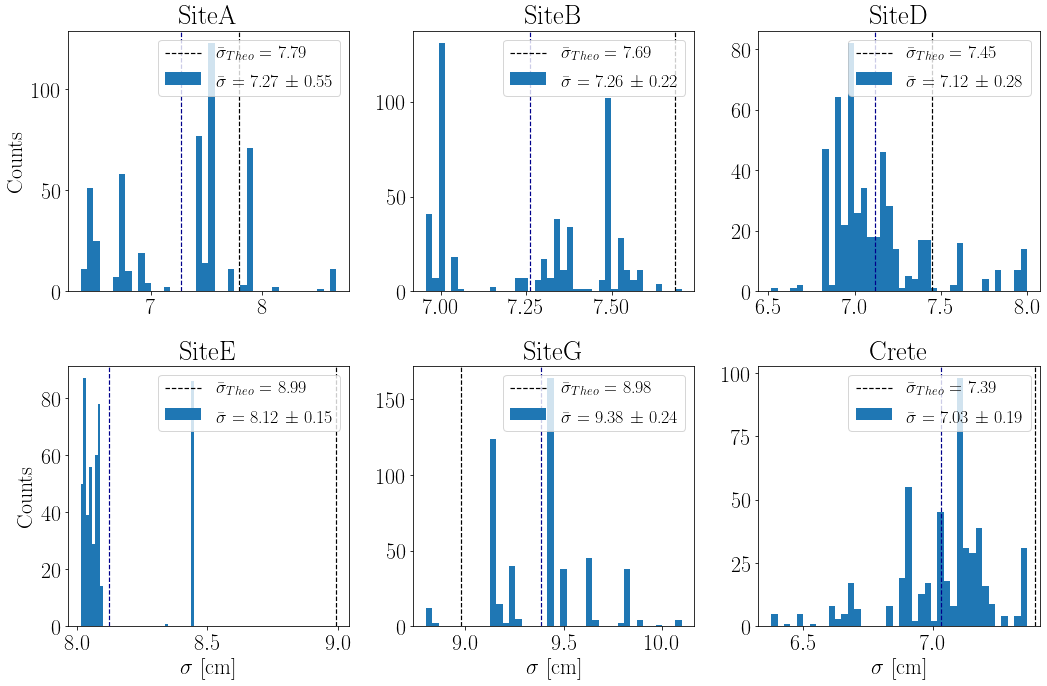

In [51]:
from DiffusionProfiles_calculations import sampling_sigma

sites = ['SiteA', 'SiteB','SiteD', 'SiteE', 'SiteG', 'Crete']

fig, axs = plt.subplots(2,3, figsize=(15,10))
for site, ax in zip(sites, axs.flatten()):
    print('\n\t##########'+site+'##########')
    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
    coreNames = CoresSpecs['CoreName']


    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTamb = CoreSpecs['dTamb']
    dLaki = CoreSpecs['dLaki']
    accum0 = CoreSpecs['Accum0']
    accumIE = CoreSpecs['Accum1']
    Temp0 = CoreSpecs['T0']+273.15
    DataAll = GetCoreData(site, 'Alphabet')

    data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
    data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
    data_dens = DataAll[4]; data_dens_LT = DataAll[5]
    data_diff = DataAll[6]; data_diff_LT = DataAll[7]
    
    depth_diff = data_diff['Depth']
    sigma_o18 = data_diff['sigma_o18']
    sigma_o18_LT = sigma_o18[(depth_diff >= dTamb) & (depth_diff <= dLaki)]
    
    sigmaTheoMean = np.mean(sigma_o18_LT)
    
    depth = data_d18O['depth']
    d18O = data_d18O['d18O']

    depth_LT = data_d18O_LT['depth']
    d18O_LT = data_d18O_LT['d18O']
    
    if site == 'SiteG' or site == 'Crete':
        dens_LT = data_dens_LT['HLmodel']
    else:
        dens_LT = data_dens_LT['HLmodelOpti']

    pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

    diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'_diffLens_GaussDistwDepths_sigNmonths2_NDCT2.csv', ' ', header=None))
    sigMin = 0.0
    sigMax = 0.15

    diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
    #dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
    #dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]


    dz_ave = np.mean(np.diff(depth_LT))
    dz_std = np.std(np.diff(depth_LT))
    diffLen_sample = sampling_sigma(dz_ave)

    print(f'Average sampling size in interval: {dz_ave*100:.2f} +/- {dz_std*100:.2f} [cm]')

    
    diffLensN_firn = np.sqrt(diffLensUse**2 - diffLen_sample**2)
    diffLensN = diffLensUse
    sigOpt_mean = np.mean(diffLensN)*100
    sigOpt_std = np.std(diffLensN)*100
    
    sigFirn_mean = np.mean(diffLensN_firn)*100
    sigFirn_std = np.std(diffLensN_firn)*100
    
    print(f'\nOpt. diff. len.: {sigOpt_mean:.2f} +/- {sigOpt_std:.2f}')
    print(f'Firn diff. len.: {sigFirn_mean:.2f} +/- {sigFirn_std:.2f}')
    
    ax.hist(diffLensN_firn*100, bins=40, label=r'$\bar{\sigma}$ = '+f'{sigFirn_mean:.2f} $\pm$ {sigFirn_std:.2f}')
    ax.axvline(sigFirn_mean, ls='--',c='darkblue',lw=1.2)
    ax.axvline(sigmaTheoMean*100, ls='--',c='k',lw=1.2, label=r'$\bar{\sigma}_{Theo}$ ='+f' {sigmaTheoMean*100:.2f}')
    ax.set_title(site)
    ax.legend(fontsize=18, loc='upper right')
    
    if site in ['SiteE', 'SiteG', 'Crete']:
        ax.set_xlabel('$\sigma$ [cm]')
    if site in ['SiteA', 'SiteE']:
        ax.set_ylabel('Counts')
    #axs.flatten()[-1].hist(Ts-273.15, bins=40, alpha=0.7, label=site)
#axs.flatten()[-1].legend(fontsize=15, ncol=2)
#axs.flatten()[-3].set_xlabel('Temperature [$^{o}$C]')
#axs.flatten()[-2].set_xlabel('Temperature [$^{o}$C]')
#axs.flatten()[-1].set_xlabel('Temperature [$^{o}$C]')
fig.tight_layout()

if saveFigs:
    fig.savefig(pathFigures + 'AllCores_sigmaEsts_wCrete.pdf')

# Temperatures


	##########SiteA##########
Average sampling size in interval: 3.92 +/- 0.06 [cm]

Opt. diff. len.: 7.37 +/- 0.54
Firn diff. len.: 7.27 +/- 0.55


<ipython-input-49-33203ff7bfeb>:19: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')



St. St. temp, opt: -31.04 +/- 2.02
St. St. temp, firn: -31.41 +/- 2.07


	##########SiteB##########
Average sampling size in interval: 3.89 +/- 0.06 [cm]

Opt. diff. len.: 7.35 +/- 0.22
Firn diff. len.: 7.26 +/- 0.22

St. St. temp, opt: -30.46 +/- 0.83
St. St. temp, firn: -30.81 +/- 0.85


	##########SiteD##########
Average sampling size in interval: 3.77 +/- 0.06 [cm]

Opt. diff. len.: 7.21 +/- 0.28
Firn diff. len.: 7.12 +/- 0.28

St. St. temp, opt: -30.00 +/- 1.05
St. St. temp, firn: -30.35 +/- 1.07


	##########SiteE##########
Average sampling size in interval: 4.25 +/- 0.07 [cm]

Opt. diff. len.: 8.22 +/- 0.15
Firn diff. len.: 8.12 +/- 0.15

St. St. temp, opt: -30.80 +/- 0.48
St. St. temp, firn: -31.14 +/- 0.49


	##########SiteG##########
Average sampling size in interval: 4.10 +/- 0.07 [cm]

Opt. diff. len.: 9.46 +/- 0.24
Firn diff. len.: 9.38 +/- 0.24

St. St. temp, opt: -25.93 +/- 0.70
St. St. temp, firn: -26.18 +/- 0.71


	##########Crete##########
No ECM file found, setting 

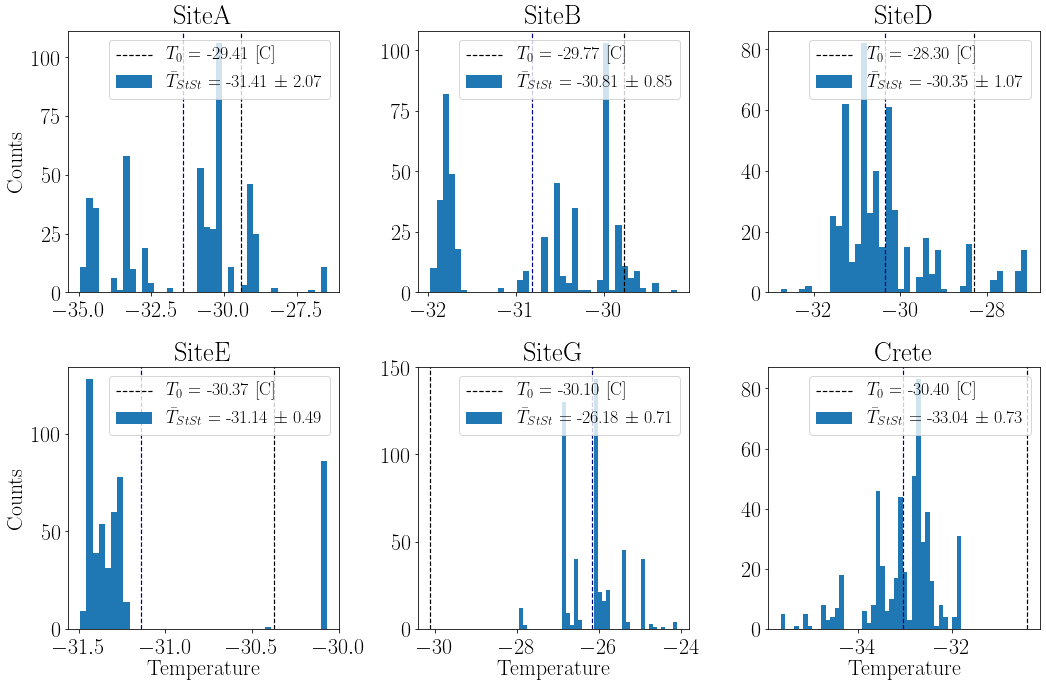

In [49]:
from DiffusionProfiles_calculations import sampling_sigma

sites = ['SiteA', 'SiteB','SiteD', 'SiteE', 'SiteG', 'Crete']

fig, axs = plt.subplots(2,3, figsize=(15,10))
for site, ax in zip(sites, axs.flatten()):
    print('\n\t##########'+site+'##########')
    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
    coreNames = CoresSpecs['CoreName']


    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTamb = CoreSpecs['dTamb']
    dLaki = CoreSpecs['dLaki']
    accum0 = CoreSpecs['Accum0']
    accumIE = CoreSpecs['Accum1']
    Temp0 = CoreSpecs['T0']+273.15
    DataAll = GetCoreData(site, 'Alphabet')

    data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
    data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
    data_dens = DataAll[4]; data_dens_LT = DataAll[5]
    data_diff = DataAll[6]; data_diff_LT = DataAll[7]

    
    depth = data_d18O['depth']
    d18O = data_d18O['d18O']

    depth_LT = data_d18O_LT['depth']
    d18O_LT = data_d18O_LT['d18O']
    
    if site == 'SiteG' or site == 'Crete':
        dens_LT = data_dens_LT['HLmodel']
    else:
        dens_LT = data_dens_LT['HLmodelOpti']

    pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

    diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'_diffLens_GaussDistwDepths_sigNmonths2_NDCT2.csv', ' ', header=None))
    sigMin = 0.0
    sigMax = 0.15

    diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
    #dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
    #dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]


    dz_ave = np.mean(np.diff(depth_LT))
    dz_std = np.std(np.diff(depth_LT))
    diffLen_sample = sampling_sigma(dz_ave)

    print(f'Average sampling size in interval: {dz_ave*100:.2f} +/- {dz_std*100:.2f} [cm]')

    
    diffLensN_firn = np.sqrt(diffLensUse**2 - diffLen_sample**2)
    diffLensN = diffLensUse
    sigOpt_mean = np.mean(diffLensN)*100
    sigOpt_std = np.std(diffLensN)*100
    
    sigFirn_mean = np.mean(diffLensN_firn)*100
    sigFirn_std = np.std(diffLensN_firn)*100
    
    print(f'\nOpt. diff. len.: {sigOpt_mean:.2f} +/- {sigOpt_std:.2f}')
    print(f'Firn diff. len.: {sigFirn_mean:.2f} +/- {sigFirn_std:.2f}')
    
        # Determine temperature interval estimate (analytical solution to diffusion equation)
    accum = accum0
    rhoMean = np.mean(dens_LT)*1000

    sigmaSolver_inst = sigma_Solver()

        # Compute for both firn and total diffusion length estimate
    T_intEst = np.zeros(len(diffLensN))
    T_firn_intEst = np.zeros(len(diffLensN))

    for i in range(len(diffLensN)):
        T_est = sigmaSolver_inst.solveTemp(Tmodel=Temp0, sigma_data = diffLensN[i], accum = accum, rho_CO=rhoMean)
        T_firn_est = sigmaSolver_inst.solveTemp(Tmodel=Temp0,sigma_data = diffLensN_firn[i], accum = accum, rho_CO=rhoMean)

        T_intEst[i] = T_est
        T_firn_intEst[i] = T_firn_est
    
    T_mean = np.mean(T_firn_intEst-273.15)
    T_std = np.std(T_firn_intEst-273.15)
    T_mean1 = np.mean(T_intEst-273.15)
    T_std1 = np.std(T_intEst-273.15)

    print(f'\nSt. St. temp, opt: {T_mean1:.2f} +/- {T_std1:.2f}')
    print(f'St. St. temp, firn: {T_mean:.2f} +/- {T_std:.2f}\n')
    
    
    rhosUse = np.ones_like(diffLensUse)*804.3

    Ts = T_firn_intEst
    T_mean = np.mean(Ts-273.15)
    T_std = np.std(Ts-273.15)


    #fig, ax = plt.subplots(figsize=(8,6))
    ax.hist(Ts-273.15, bins=40, label=r'$\bar{T}_{StSt}$ = '+f'{T_mean:.2f} $\pm$ {T_std:.2f}')
    ax.axvline(Temp0-273.15, ls='--',c='k',lw=1.2, label=f'$T_0$ = {Temp0-273.15:.2f} [C]')
    ax.axvline(T_mean, ls='--',c='darkblue',lw=1.2)
    ax.set_title(site)
    ax.legend(fontsize=18, loc='upper right')
    
    if site in ['SiteE', 'SiteG', 'Crete']:
        ax.set_xlabel('Temperature')
    if site in ['SiteA', 'SiteE']:
        ax.set_ylabel('Counts')
    #axs.flatten()[-1].hist(Ts-273.15, bins=40, alpha=0.7, label=site)
#axs.flatten()[-1].legend(fontsize=15, ncol=2)
#axs.flatten()[-3].set_xlabel('Temperature [$^{o}$C]')
#axs.flatten()[-2].set_xlabel('Temperature [$^{o}$C]')
#axs.flatten()[-1].set_xlabel('Temperature [$^{o}$C]')
fig.tight_layout()

if saveFigs:
    fig.savefig(pathFigures + 'AllCores_StStTempEsts_wCrete.pdf')

# Appendices

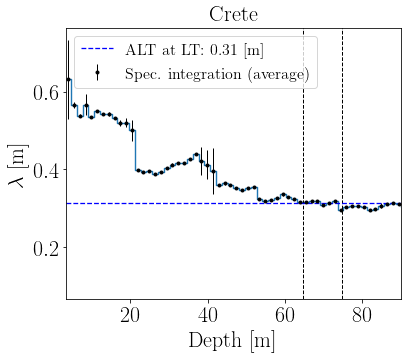